Today, I figured out an answer to a question that I didn't find asked anywhere on the internet. In case someone else (or me) asks this question later, I wanted to write up my solution for reference. This post goes over how to access and manipulate the right y-axis labels on a [seaborn FacetGrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) plot which was made with `margin_titles = True`.

I'll just go through one example that the FacetGrid documentation already has, and show how you could go into the axes object to manipulate the right-hand ylabel.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

tips = sns.load_dataset("tips")

This is the original plot with `margin_titles = True`, using plotting code copied from the doc page and slightly simplified:

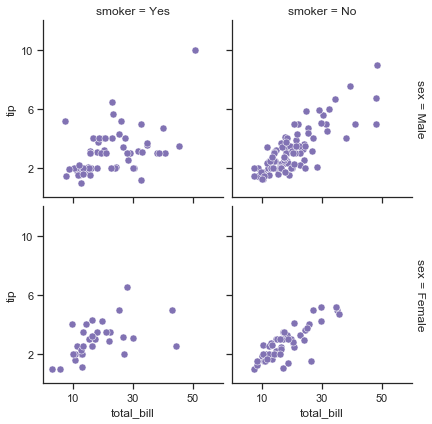

In [8]:
kws = dict(s=50, linewidth=.5, edgecolor="w")

# Set up the FacetGrid
g = sns.FacetGrid(tips, col="smoker", row="sex",
                   margin_titles=True)

# Make the plot
g = g.map(plt.scatter, "total_bill", "tip", color="m", **kws)

# Make some changes to the axes, etc (from seaborn documentation)
g.set(xlim=(0, 60), ylim=(0, 12),
      xticks=[10, 30, 50], yticks=[2, 6, 10])
g.fig.subplots_adjust(wspace=.05, hspace=.05)


I figured out a while ago that you can access each individual axes object by calling `g.axes`. This means that you can loop over each axis and use normal calls like `ax.set_title()` and others on each axis. But when I tried this to access the righthand y-axis labels, for example to increase the font size, I wasn't seeing any difference in the plot:

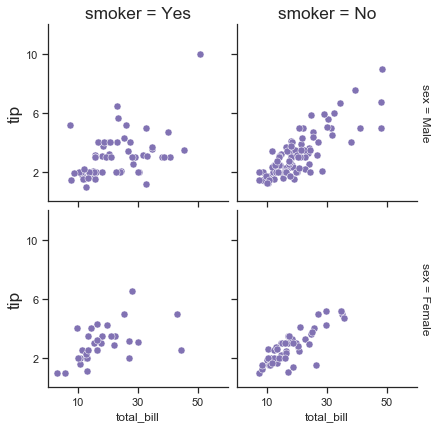

In [9]:
g = sns.FacetGrid(tips, col="smoker", row="sex",
                   margin_titles=True)
g = g.map(plt.scatter, "total_bill", "tip", color="m", **kws)    
g.set(xlim=(0, 60), ylim=(0, 12),
      xticks=[10, 30, 50], yticks=[2, 6, 10])
g.fig.subplots_adjust(wspace=.05, hspace=.05)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='xx-large')

I dug around the axes objects quite a bit using various calls to `dir(ax)`, until I found an attribute called `texts` and which seemed to contain the correct text:

In [17]:
dir(ax)[390:400]

['sticky_edges',
 'streamplot',
 'table',
 'tables',
 'text',
 'texts',
 'tick_params',
 'ticklabel_format',
 'title',
 'titleOffsetTrans']

In [18]:
ax.texts

[Text(1.02,0.5,u'sex = Female')]

That means that the righthand ylabels are probably just being manually coded in through a call to `ax.text()`, so we can presumably just grab the correct location and text and just change the parameters we want:

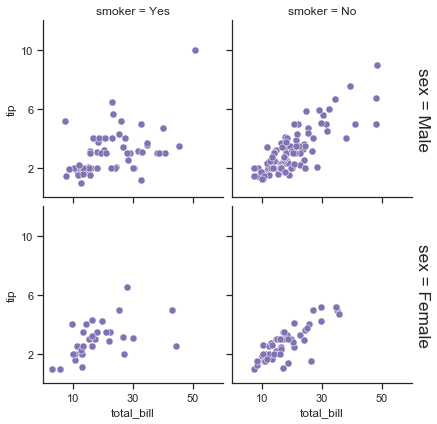

In [21]:
g = sns.FacetGrid(tips, col="smoker", row="sex",
                   margin_titles=True)
g = g.map(plt.scatter, "total_bill", "tip", color="m", **kws)    
g.set(xlim=(0, 60), ylim=(0, 12),
      xticks=[10, 30, 50], yticks=[2, 6, 10])
g.fig.subplots_adjust(wspace=.05, hspace=.05)

# Iterate thorugh each axis
for ax in g.axes.flat:
    
    # Only the 2nd and 4th axes have something in ax.texts
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1], 
                txt.get_text(), 
                transform=ax.transAxes,
                va='center',
                fontsize='xx-large',
                rotation=-90)
        # Remove the original text
        ax.texts[0].remove()

Ta da! Now we know how to access that text and change it to our bidding! We can make it even better (this is how I tend to process my FacetGrid plots for publications):

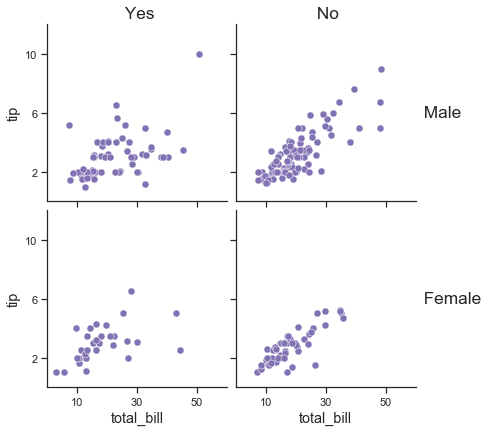

In [25]:
g = sns.FacetGrid(tips, col="smoker", row="sex",
                   margin_titles=True)
g = g.map(plt.scatter, "total_bill", "tip", color="m", **kws)    
g.set(xlim=(0, 60), ylim=(0, 12),
      xticks=[10, 30, 50], yticks=[2, 6, 10])
g.fig.subplots_adjust(wspace=.05, hspace=.05)

# Iterate thorugh each axis
for ax in g.axes.flat:
    # Make x and y-axis labels slightly larger
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

    # Make title more human-readable and larger
    if ax.get_title():
        ax.set_title(ax.get_title().split('=')[1], 
                     fontsize='xx-large')

    # Make right ylabel more human-readable and larger
    # Only the 2nd and 4th axes have something in ax.texts
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1], 
                txt.get_text().split('=')[1], 
                transform=ax.transAxes,
                va='center',
                fontsize='xx-large')
        # Remove the original text
        ax.texts[0].remove()